# Codice per l'importazione delle immagini

**Le immagini devono essere già organizzate nel seguente modo:**


```
- DatasetFolder
  - Train (75% del dataset)
    - Good
    - Cracked
  - Validation(25% del dataset)
    - Good
    - Cracked
```
*NB: La cartella deve essere zippata e messa nel proprio Google Drive facendo in modo che la posizione del file coincida con percorso indicato dalla variabile local_zip.*

Lo zip viene poi estratto localmente mantenendo la gerarchia interna delle cartelle. Questo passaggio è fondamentale, perchè l'applicazione delle labels viene fatta in base all'organizzazione delle cartelle, grazie alle librerie messe a disposizione da TensorFlow.

In [0]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')

local_zip = 'drive/My Drive/Colab Notebooks/dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with good tomatoes images for training
train_gt_dir = os.path.join(train_dir, 'good')

# Directory with cracked tomatoes images for training
train_ct_dir = os.path.join(train_dir, 'cracked')

# Directory with good tomatoes images for validation
validation_gt_dir = os.path.join(validation_dir, 'good')

# Directory with cracked tomatoes images for validation
validation_ct_dir = os.path.join(validation_dir, 'cracked')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Codice per la generazione dei set di training e validation

In questa sezione vengono applicate delle trasformazioni alle immagini affinchè si eviti l'overfitting del modello al dataset.

Ci sono inoltre i due generatori per il dataset di training e di validation, che prendono in ingresso le cartelle precedentemente generate e nei quali si decidono le dimensioni delle immagini, le dimensioni del batch e la tipologia di classe (che in questo specifico caso è binario - good/cracked). 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=40, # is a value in degrees (0–180), a range within which to randomly rotate pictures.
  width_shift_range=0.2, # range (as a fraction of total width) within which to randomly translate pictures horizontally
  height_shift_range=0.2, # range (as a fraction of total height) within which to randomly translate pictures vertically
  shear_range=0.2, # is for randomly applying shearing transformations
  zoom_range=0.2, # is for randomly zooming inside pictures
  horizontal_flip=True, # is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
  fill_mode='nearest') # is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

training_generator = training_datagen.flow_from_directory(
  train_dir,
  target_size=(224, 224),
  batch_size=20,
  class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=(224, 224),
  batch_size=20,
  class_mode='binary')

Found 862 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


# Custom CNN from scratch
Rete neurale costruita da zero, richiede la scelta dei layer (numero, hidden layers, tipologia) e dei parametri per la compilazione del modello

In [0]:
# CNN from scratch

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 224x224x3: 224x224 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(224, 224, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

# Outputs a summary of the model, showing the dimensions and number of the resulting filters
# model.summary()

# NB: Adagrad or Adam could be better than binary_crossentropy
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

W0714 13:14:20.664673 140410100152192 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0714 13:14:20.896088 140410100152192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Modello pretrained MobileNet con i pesi di ImageNet

In questa sezione si utilizza alla base della CNN un modello pre allenato (MobileNet) con i pesi di ImageNet.

In specifico, si utilizza tutta la rete per l'apprendimento escludendo l'ultimo livello (quello decisionale), per sfruttare al massimo l'intelligienza "generale" della rete, per poi aggiungere in cima la nostra personale CNN che esegue la decisione finale (in questo caso pomodorino good/cracked).

Si può decidere:
* Se freezare o no i livelli della rete pre allenata, questo permette di non effettuare (freezed) o effettuare (non freezed) un fine tuning per il nostro specifico caso
* Quanti livelli aggiungere al di sopra del modello pre allenato per istruire la rete a riconoscere il nostro caso specifico
* Come compilare il livello prima di iniziare il training (per questo bisogna prestare attenzione ai parametri scelti nei generatori dei set di training/validation), distinguendo i casi freezed/non freezed

In [0]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet import MobileNet

# Loading keras MobileNet model with ImageNet weigths
base_model = MobileNet(input_shape=(224,224,3), include_top=False, weights='imagenet')

# Freeze all pretrained model layers; if freezed, check the right model compiler
#for layer in base_model.layers:
#  layer.trainable = False

# Unfreeze all pretrained model layers; if unfreezed, check the right model compiler
for layer in base_model.layers:
  layer.trainable = True

x = base_model.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(base_model.input, x)

# Freezed model compiler
#model.compile(loss='binary_crossentropy',
#  optimizer=RMSprop(lr=0.0001),
#  metrics=['acc'])

# Not freezed model compiler
model.compile(
  loss='binary_crossentropy',
  optimizer=SGD(lr=0.0005, momentum=0.9),
  metrics=['acc'])

17227776/17225924 [==============================] - 1s 0us/step


# Allenamento del modello
Questo pezzo di codice serve ad avviare l'allenamento della rete; si può decidere:
* Steps per training/validation, prestando attenzione al numero di elementi nei dataset e al batch scelto per cercare di utilizzare tutte le immagini a disposizione
* Epochs per l'allenamento
* I generatori dei set di training/validation definiti precedentemente
* La verbosità dell'output

In [0]:
history = model.fit_generator(
  training_generator,
  steps_per_epoch=43,  # ~860 images = batch_size * steps
  epochs=30,
  validation_data=validation_generator,
  validation_steps=11,  # ~220 images = batch_size * steps
  verbose=2)

Epoch 1/30
43/43 - 21s - loss: 0.6148 - acc: 0.6865 - val_loss: 1.0523 - val_acc: 0.5442
Epoch 2/30
43/43 - 15s - loss: 0.4585 - acc: 0.7874 - val_loss: 0.6437 - val_acc: 0.6465
Epoch 3/30
43/43 - 15s - loss: 0.4436 - acc: 0.7957 - val_loss: 1.0746 - val_acc: 0.5488
Epoch 4/30
43/43 - 15s - loss: 0.3713 - acc: 0.8477 - val_loss: 1.6225 - val_acc: 0.5581
Epoch 5/30
43/43 - 15s - loss: 0.4164 - acc: 0.8240 - val_loss: 0.4491 - val_acc: 0.7907
Epoch 6/30
43/43 - 15s - loss: 0.3324 - acc: 0.8717 - val_loss: 0.4149 - val_acc: 0.8140
Epoch 7/30
43/43 - 15s - loss: 0.3308 - acc: 0.8682 - val_loss: 0.4912 - val_acc: 0.7767
Epoch 8/30
43/43 - 15s - loss: 0.3337 - acc: 0.8646 - val_loss: 0.2807 - val_acc: 0.8930
Epoch 9/30
43/43 - 15s - loss: 0.3206 - acc: 0.8674 - val_loss: 0.2645 - val_acc: 0.9023
Epoch 10/30
43/43 - 15s - loss: 0.2929 - acc: 0.8847 - val_loss: 0.2421 - val_acc: 0.8605
Epoch 11/30
43/43 - 15s - loss: 0.2539 - acc: 0.8791 - val_loss: 0.2342 - val_acc: 0.9209
Epoch 12/30
43/43 -

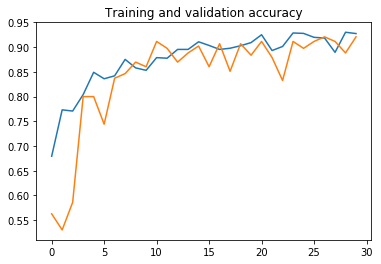

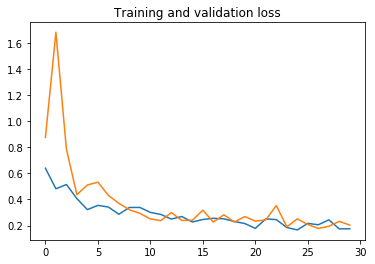

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.savefig('accuracy.png')
files.download('accuracy.png')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.savefig('loss.png')
files.download('loss.png')

# Salvataggio del modello in locale

In [0]:
# SAVE TENSORFLOW MODEL

import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend as K
from tensorflow.python.tools import freeze_graph

model_file = "model.json"
weights_file = "weights.h5"

with open(model_file, "w") as file:
  file.write(model.to_json())
  
model.save_weights(weights_file)

with open(model_file, "r") as file:
    model_json = file.read()

loaded_model = model_from_json(model_json)
loaded_model.load_weights(weights_file)

K.set_learning_phase(0)
saver = tf.train.Saver()
sess = K.get_session()
saver.save(sess, "./tf_model.ckpt")

!freeze_graph --input_meta_graph="./tf_model.ckpt.meta" --input_checkpoint="./tf_model.ckpt" --output_graph="./frozen_tf_model.pb" --output_node_names=$loaded_model.output.op.name --input_binary=true

# Funzioni varie
Funzioni varie per verificare la correttezza del dataset e le trasformazioni applicate

In [0]:
# NOT NECESSARY
# Print the number of images in each dir (good/cracked in train/validation)

print ('total training good images:', len(os.listdir(train_gt_dir)))
print ('total training cracked images:', len(os.listdir(train_ct_dir)))
print ('total validation good images:', len(os.listdir(validation_gt_dir)))
print ('total validation cracked images:', len(os.listdir(validation_ct_dir)))

total training good images: 446
total training cracked images: 416
total validation good images: 111
total validation cracked images: 104


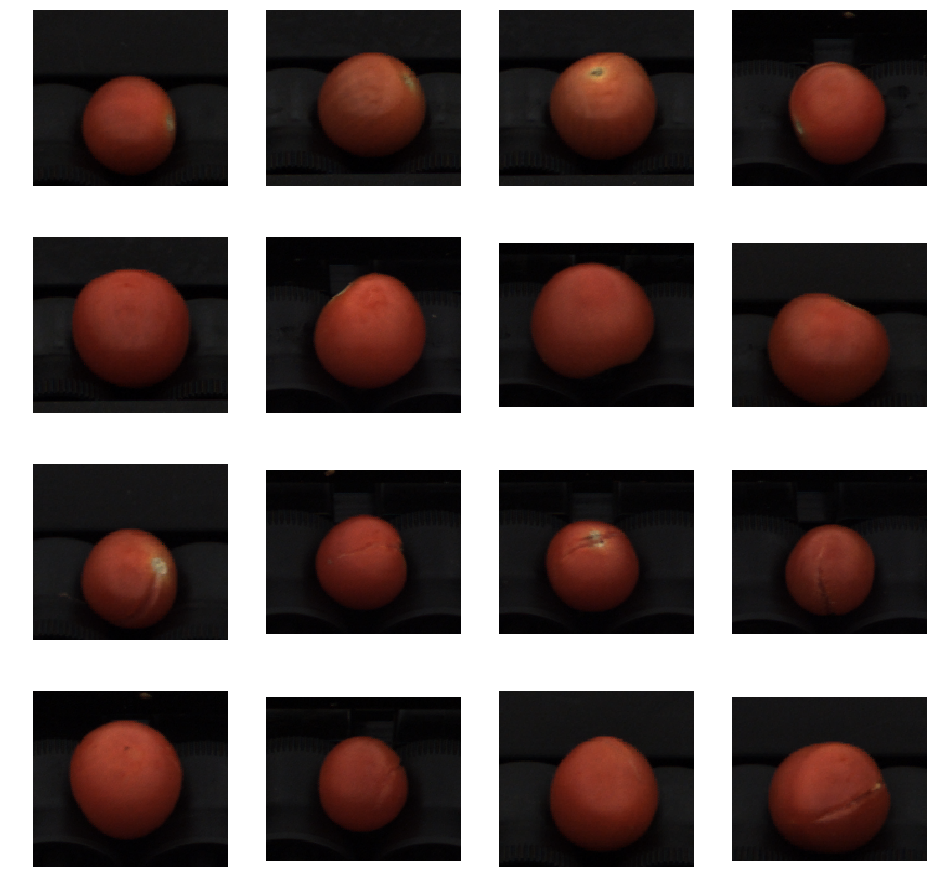

In [0]:
# NOT NECESSARY
# Outputs grids containing 8 random good and 8 random cracked tomatoes

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_gt_fnames = os.listdir(train_gt_dir)
train_ct_fnames = os.listdir(train_ct_dir)

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_gt_pix = [os.path.join(train_gt_dir, fname) 
                for fname in train_gt_fnames[pic_index-8:pic_index]]
next_ct_pix = [os.path.join(train_ct_dir, fname) 
                for fname in train_ct_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_gt_pix+next_ct_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


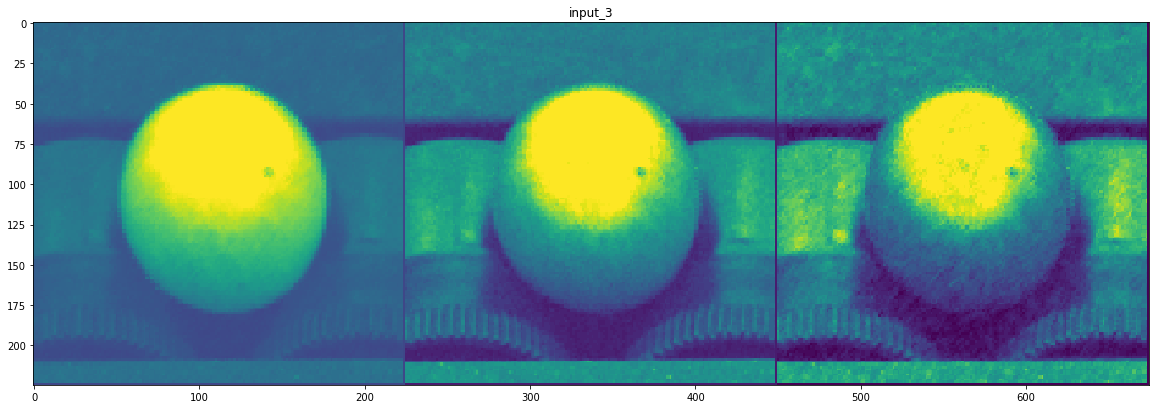

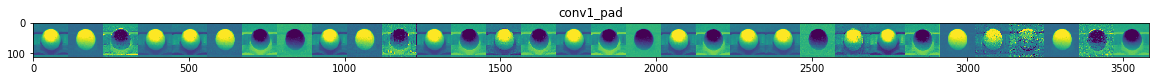

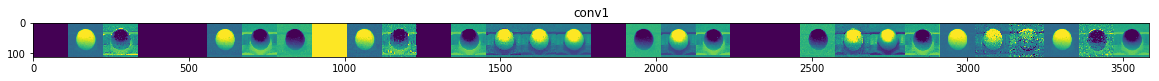

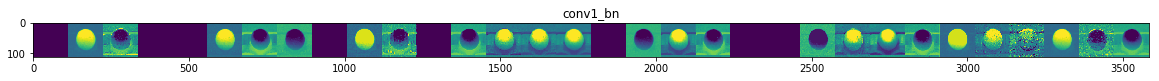

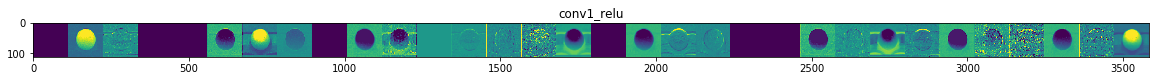

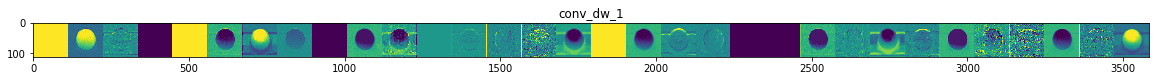

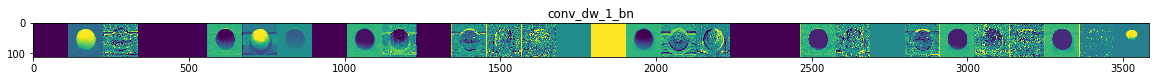

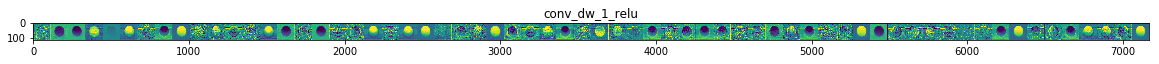

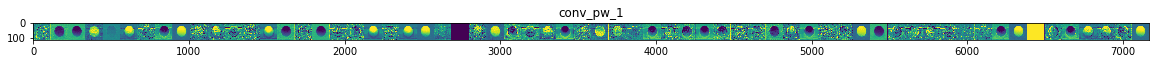

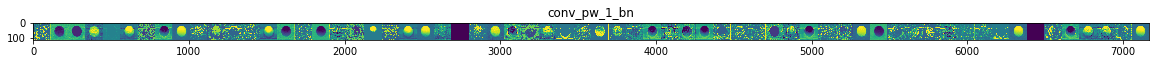

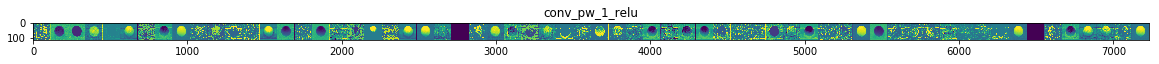

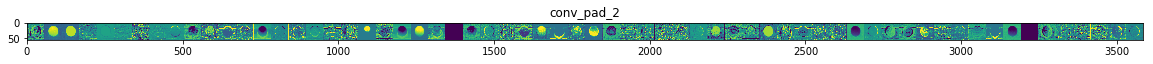

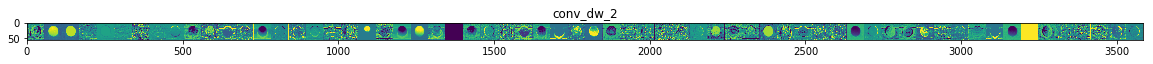

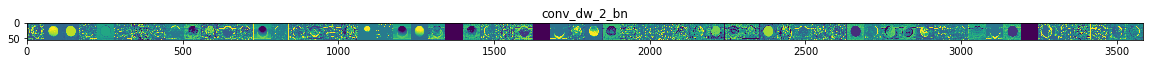

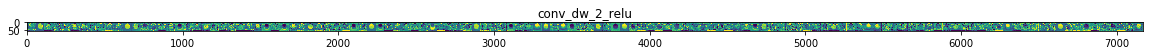

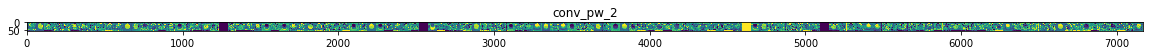

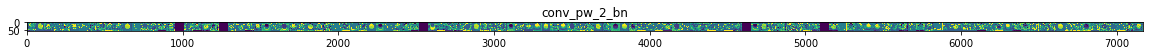

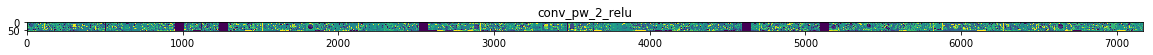

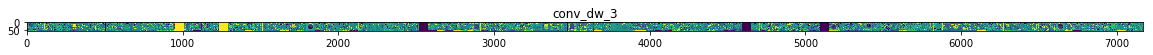

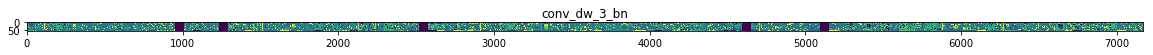

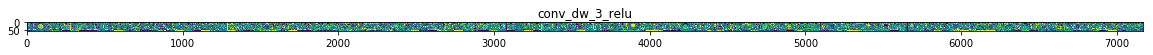

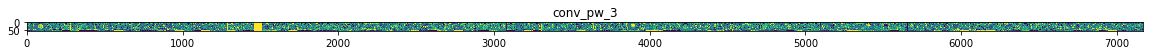

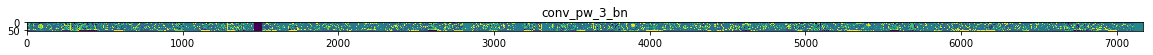

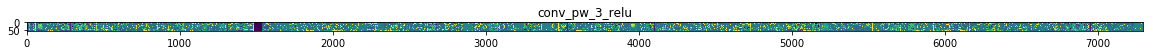

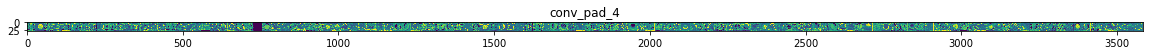

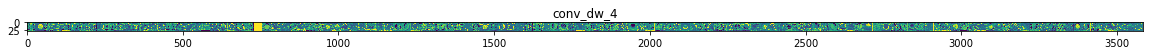

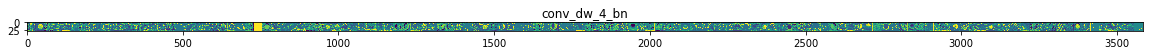

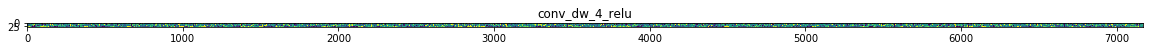

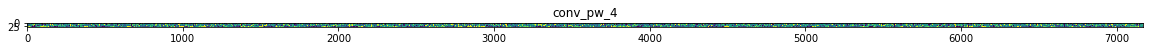

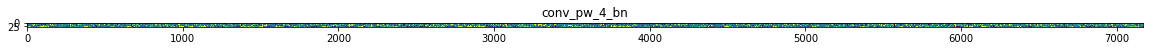

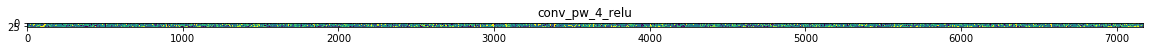

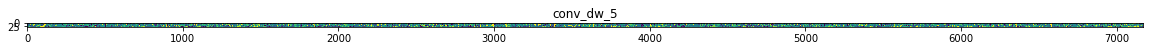

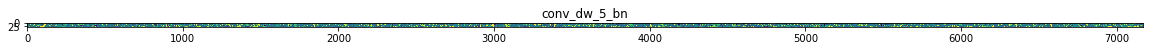

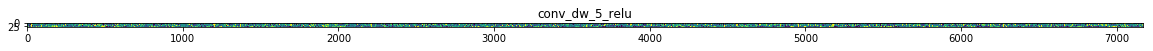

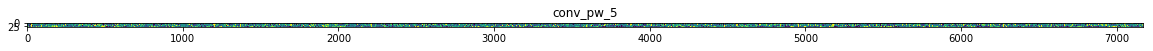

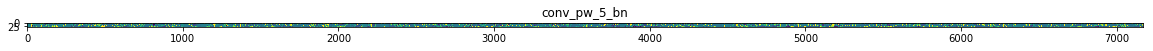

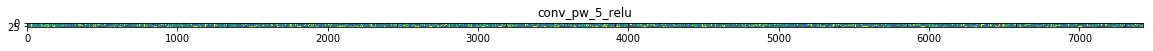

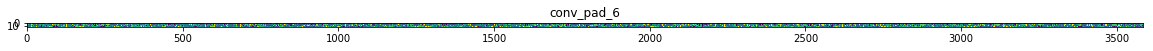

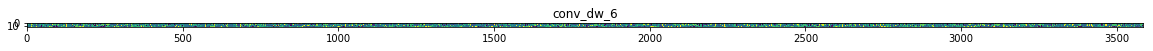

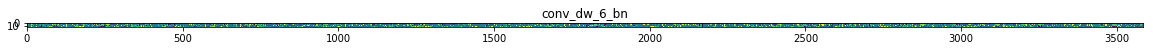

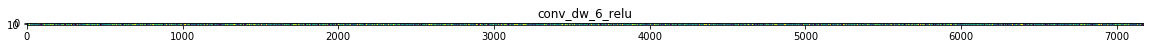

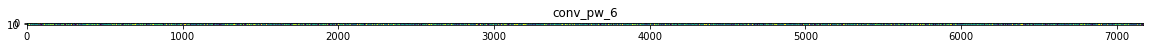

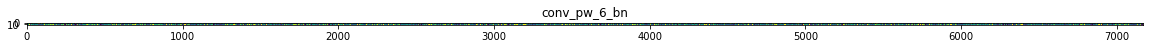

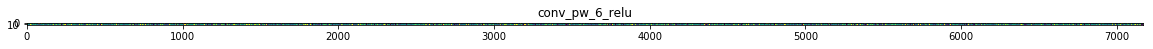

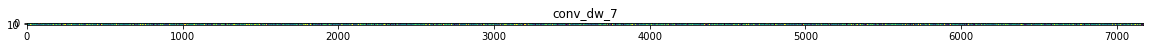

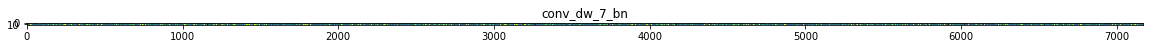

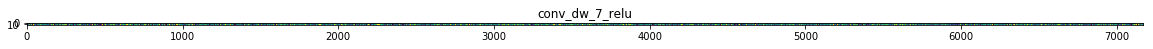

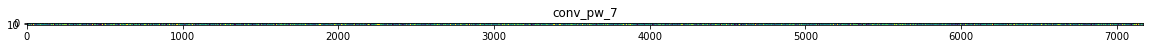

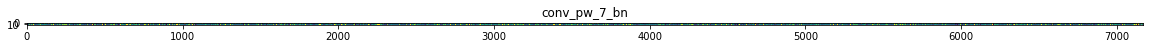

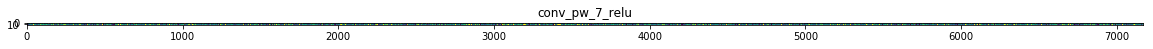

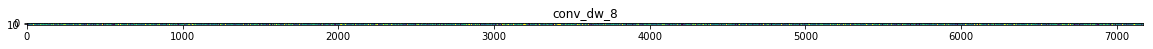

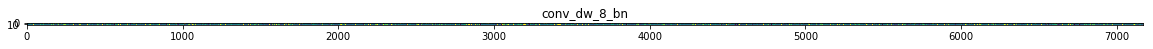

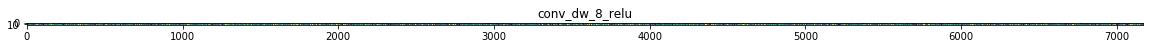

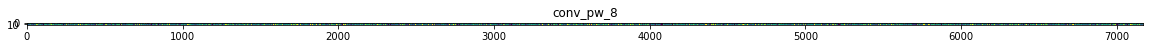

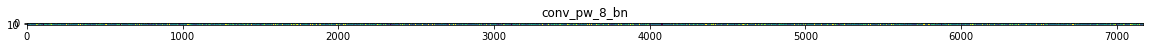

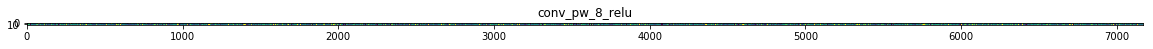

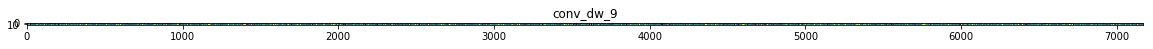

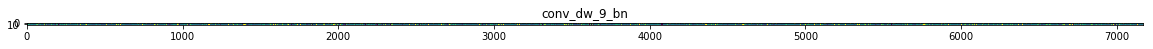

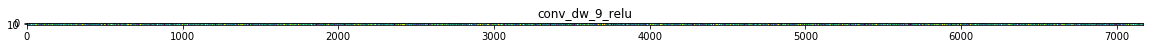

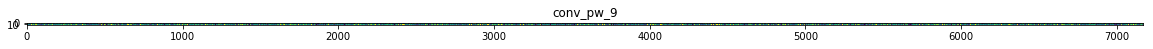

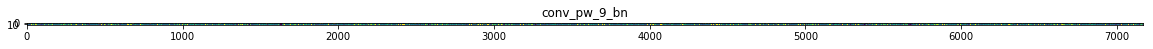

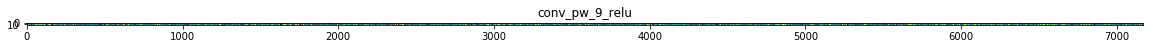

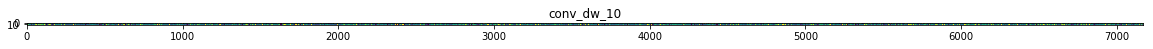

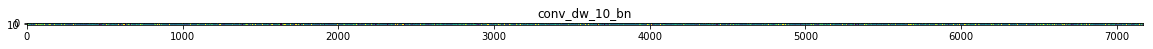

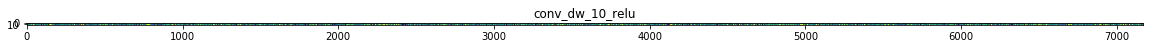

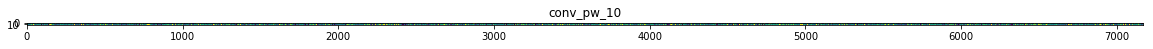

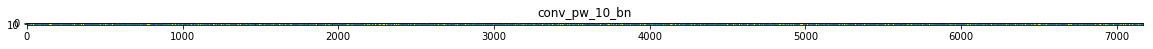

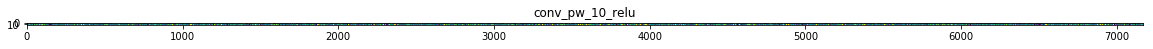

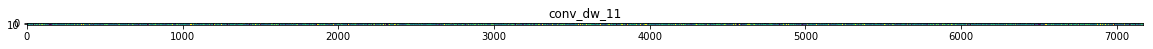

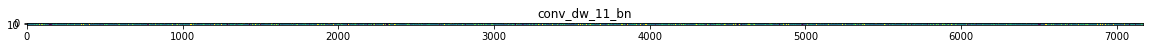

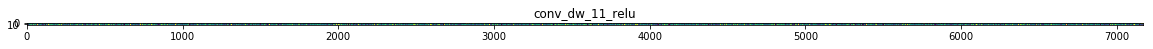

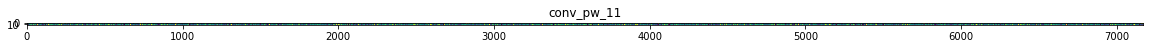

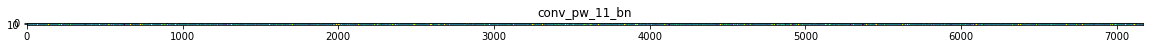

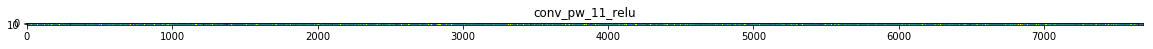

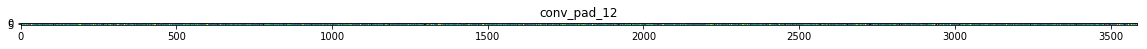

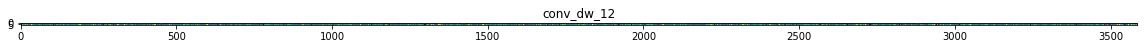

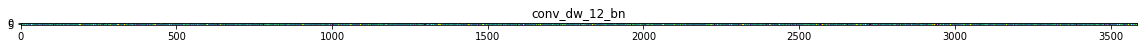

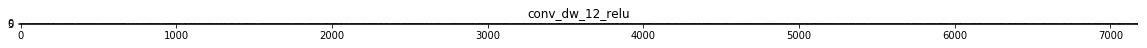

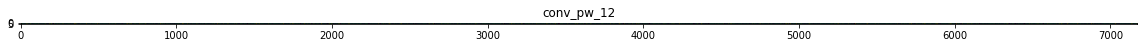

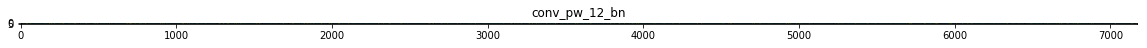

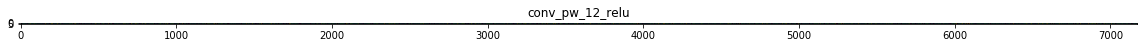

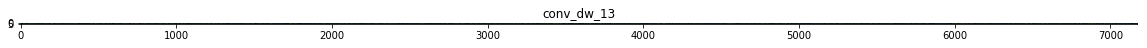

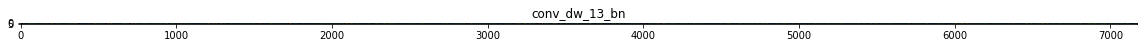

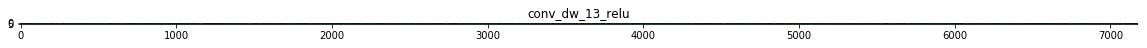

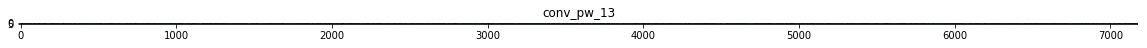

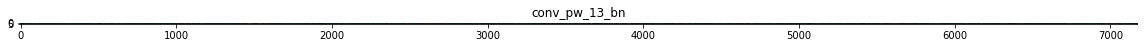

In [0]:
# NOT NECESSARY
# Outputs a graph showing the type of transformations applied to the images
# in order to extract the important features of them

import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(model.input, successive_outputs)

# Let's prepare a random input image of a good or cracked tomatoe from the training set.
gt_img_files = [os.path.join(train_gt_dir, f) for f in train_gt_fnames]
ct_img_files = [os.path.join(train_ct_dir, f) for f in train_ct_fnames]
img_path = random.choice(gt_img_files + ct_img_files)

img = load_img(img_path, target_size=(224, 224))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Test
Codice per testare il modello su immagini custom; è necessario caricare l'immagine da sottoporre alla rete manualmente e poi indicare il suo percorso corretto.

In [0]:
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

good_tomatoe = load(f"{validation_gt_dir}/0025_Color.png")
cracked_tomatoe = load(f"{validation_ct_dir}/0001_Color.png")
model.predict(good_tomatoe)

[array([[0.9880264]], dtype=float32), array([[0.08464047]], dtype=float32)]


# Precision e Recall
Codice che sfrutta tutto il validation set per calcolare precision e recall del modello.
Usa le funzioni matematiche:
*   Precision = TP / TP + FP
*   Recall = TP / TP + FN



In [0]:
from os import listdir
from PIL import Image
import numpy as np
from skimage import transform

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image


true_positives = 0
false_positives = 0
false_negatives = 0

good_dir = "/tmp/dataset/validation/good/"
cracked_dir = "/tmp/dataset/validation/cracked/"


for f in listdir(good_dir):
  
  file = good_dir + f
  image = load(file)
  prediction = model.predict(image)[0][0]
  
  if prediction > 0.5:
    true_positives += 1
  else: false_negatives +=1

for f in listdir(cracked_dir):
  
  file = cracked_dir + f
  image = load(file)
  prediction = model.predict(image)[0][0]
  
  if prediction > 0.5:
    false_positives += 1
  
recall = true_positives / (true_positives + false_negatives)
precision = true_positives /(true_positives + false_positives)

print('Recall:', recall)
print('Precision:', precision)

Recall: 0.9369369369369369
Precision: 0.9369369369369369


# Clean up
Codice utile a fare pulizia della ram nel caso di raggiungimento del limite; è comodo perchè evita di cancellare completamente il dataset caricato (cosa che richiederebbe un nuovo e fastidioso upload)

In [0]:
# Piece of code to clean up7

import os, signal
os.kill(os.getpid(), signal.SIGKILL)